In [8]:
import time
import requests
import pandas as pd
from datetime import datetime, date, time as dt_time, timedelta
from zoneinfo import ZoneInfo
from IPython.display import clear_output
import requests
import pandas_ta as ta
from rdp import rdp
import talib
import numpy as np
import pandas_ta as ta
from scipy.stats import zscore
from scipy.signal import savgol_filter
from datetime import datetime, date, time as dt_time, timedelta
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt

# ── CONFIG ─────────────────────────────────────────────────────────────────
API_KEY = "vBRy5un9PuHfxFj1IrHpfg8a2RS57jE9"

# https://github.com/polygon-io/client-python/blob/master/examples/websocket/stocks-ws.py


In [9]:
def fetch_polygon_data(ticker: str, api_key: str,
                              start_date: date,
                              end_date: date,
                              start_time: dt_time,
                              end_time: dt_time = dt_time(16, 0),
                              multiplier: int = 1,
                              timespan: str = "minute",
                              limit: int = 50000) -> pd.DataFrame:
    """
    Fetches intraday minute-level OHLCV data for a given ticker from Polygon.io.

    Args:
        ticker (str): Stock ticker symbol (e.g., "TSLA").
        api_key (str): Your Polygon.io API key.
        start_date (date): The date for which to fetch data.
        end_date (date): The date for which to end fetch data.
        start_time (datetime.time): Start of time window in EST.
        end_time (datetime.time): End of time window in EST.
        multiplier (int): Interval multiplier (default 1 minute).
        timespan (str): Time unit ("minute", "hour", etc.).
        limit (int): Maximum number of results to retrieve.

    Returns:
        pd.DataFrame: A filtered DataFrame with renamed columns and timestamps in EST.
    """
    ET_ZONE = ZoneInfo("America/New_York")

    url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/{multiplier}/{timespan}/{start_date}/{end_date}"
    params = {
        "apiKey": api_key,
        "adjusted": "true",
        "sort": "asc",
        "limit": limit
    }

    session = requests.Session()
    response = session.get(url, params=params)
    response.raise_for_status()

    bars = response.json().get("results", [])
    df = pd.DataFrame(bars)

    if df.empty:
        return pd.DataFrame()  # Return empty DataFrame if no data

    df["TIME_UTC"] = pd.to_datetime(df["t"], unit="ms", utc=True)
    df["TIME_EST"] = df["TIME_UTC"].dt.tz_convert(ET_ZONE)
    del df["TIME_UTC"]

    # Define time window
    start_dt = datetime.combine(start_date, start_time, tzinfo=ET_ZONE)
    end_dt = datetime.combine(end_date, end_time, tzinfo=ET_ZONE)

    # Filter and rename
    df = df[(df["TIME_EST"] >= start_dt) & (df["TIME_EST"] <= end_dt)].copy()
    df.rename(columns={
        "o": "open",
        "h": "high",
        "l": "low",
        "c": "close",
        "v": "volume",
        "n": "trades",
        "vw": "vwap"
    }, inplace=True)

    return df


In [10]:
def add_indicators_and_signals(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds technical indicators, buy conditions, and entry signal column to the given DataFrame.
    Assumes columns: 'open', 'high', 'low', 'close', 'volume'


    Returns:
        DataFrame with new columns added.
    """

    # Bollinger Bands_________________________________________________________
    # ________________________________________________________________________

    up, _, dn = talib.BBANDS(df.close.values, timeperiod=20, nbdevup=2, nbdevdn=2)
    df['BB_up_2'], df['BB_dn_2'] = up, dn

    up, _, dn = talib.BBANDS(df.close.values, timeperiod=20, nbdevup=1, nbdevdn=1)
    df['BB_up_1'], df['BB_dn_1'] = up, dn

    # VWAP (Cumulative approximation)_________________________________________
    # ________________________________________________________________________

    start_time = dt_time(4, 0)   # ex.,4:00 AM ET
    end_time = dt_time(23, 59)  

    mask = (df['TIME_EST'].dt.time >= start_time) & (df['TIME_EST'].dt.time <= end_time)
    df_trading = df.loc[mask].copy()

    df.loc[mask, 'VWAP_Cum'] = ((df.loc[mask, 'close'] * df.loc[mask, 'volume']).groupby(df.loc[mask, 'TIME_EST'].dt.date).cumsum()
                                /
                                df.loc[mask, 'volume'].groupby(df.loc[mask, 'TIME_EST'].dt.date).cumsum())

    # EMA, MACD, ATR, SMA ____________________________________________________
    # ________________________________________________________________________

    macd, sig, hist = talib.MACD(df.close.values, fastperiod=12, slowperiod=26, signalperiod=9)
    df['MACD'], df['Signal'], df['MACD_hist'] = macd, sig, hist

    # EMA, MACD, ATR, SMA     ----------------------------
    df['EMA9'] = talib.EMA(df.close.values, timeperiod=9)
    df['EMA20'] = talib.EMA(df.close.values, timeperiod=20)
    df['EMA50'] = talib.EMA(df.close.values, timeperiod=50)
    df['EMA200'] = talib.EMA(df.close.values, timeperiod=200)

    macd, sig, hist = talib.MACD(df.close.values, fastperiod=12, slowperiod=26, signalperiod=9)
    df['MACD'], df['Signal'], df['MACD_hist'] = macd, sig, hist
    df["MACD_hist_smooth_EMA"] = df["MACD_hist"].ewm(span=5, adjust=False).mean()

    df['SMA5'] = talib.SMA(df.close.values, timeperiod=5)
    df['SMA20'] = talib.SMA(df.close.values, timeperiod=20)
    df['SMA50'] = talib.SMA(df.close.values, timeperiod=50)
    df['SMA200'] = talib.SMA(df.close.values, timeperiod=200)

    # RSI                     ----------------------------  
    df['RSI'] = talib.RSI(df.close.values, timeperiod=14)
    
    # TSI                     ________________________________________________
    # ________________________________________________________________________

    tsi_df = ta.tsi(df['close'], long=25*4, short=13*4, signal=8*4)
    tsi_df.index = df.index  # Align index to match df
    tsi_df.columns = ['TSI', 'TSI_signal']
    df = df.join(tsi_df)
    
    # Confriming Signal_______________________________________________________
    # ________________________________________________________________________
    
    df['SMA200_VL']=df['SMA200'].diff()
    df['SMA50_VL']=df['SMA50'].diff()

    # zscored_signal = zscore(df[['SMA50_VL','SMA200_VL']].values, axis=0, ddof=0, nan_policy='omit')
    # df[['SMA50_VL_ZSCR', 'SMA200_VL_ZSCR']] = zscored_signal
    
    # --- Daily z-score of the diff columns (resets each day) ---
    _seg = df.loc[mask] 
    
    out = (
        _seg
        .groupby(_seg['TIME_EST'].dt.date, group_keys=False)[['SMA50_VL','SMA200_VL']]
        .apply(lambda g: pd.DataFrame(
            zscore(g.to_numpy(), axis=0, ddof=0, nan_policy='omit'),
            index=g.index,
            columns=['SMA50_VL_ZSCR_DAY','SMA200_VL_ZSCR_DAY']
        ))
    )

    # Assign back aligned by index
    df[['SMA50_VL_ZSCR_DAY','SMA200_VL_ZSCR_DAY']] = np.nan
    df.loc[out.index, ['SMA50_VL_ZSCR_DAY','SMA200_VL_ZSCR_DAY']] = out
    
    # smoothed Signal         ----------------------------
    df['SMA50_VL_smooth'] = savgol_filter(df['SMA50_VL'], window_length=100, polyorder=7)
    df['SMA200_VL_smooth'] = savgol_filter(df['SMA200_VL'], window_length=150, polyorder=7)

    zscored_signal= zscore(df[['SMA50_VL_smooth','SMA200_VL_smooth']].values, axis=0, ddof=0, nan_policy='omit')
    df[['SMA50_VL_ZSCR_smooth', 'SMA200_VL_ZSCR_smooth']] = zscored_signal 

    # --- Daily z-score of the smoothed columns (resets each day) ---
    _seg = df.loc[mask] 
    
    out = (
        _seg
        .groupby(_seg['TIME_EST'].dt.date, group_keys=False)[['SMA50_VL_smooth','SMA200_VL_smooth']]
        .apply(lambda g: pd.DataFrame(
            zscore(g.to_numpy(), axis=0, ddof=0, nan_policy='omit'),
            index=g.index,
            columns=['SMA50_VL_ZSCR_smooth_DAY','SMA200_VL_ZSCR_smooth_DAY']
        ))
    )
    
    # Assign back aligned by index
    df[['SMA50_VL_ZSCR_smooth_DAY','SMA200_VL_ZSCR_smooth_DAY']] = np.nan
    df.loc[out.index, ['SMA50_VL_ZSCR_smooth_DAY','SMA200_VL_ZSCR_smooth_DAY']] = out

    return df
    

In [11]:
from datetime import date
import time
from typing import List, Dict

def fetch_multiple_tickers_data(ticker: List[str],
                                api_key: str,
                                start_date: date,
                                end_date: date,
                                start_time: dt_time,
                                end_time: dt_time,
                                multiplier: int,
                                timespan: str,
                                limit: int ,
                                delay: float = 0.25) -> Dict[str, pd.DataFrame]:
    """
    Fetch minute-level Polygon data for multiple tickers on a given date.

    Args:
        ticker (List[str]): List of stock ticker symbols.
        api_key (str): Your Polygon.io API key.
        start_date (date): The date for which to fetch intraday data.
        delay (float): Seconds to wait between API calls (rate limit buffer).

    Returns:
        Dict[str, pd.DataFrame]: Dictionary of ticker symbol → DataFrame.
    """
    all_data = {}

    for ticker in ticker:
        try:
            df = fetch_polygon_data(
                ticker=ticker,
                api_key=API_KEY,
                start_date=start_date,
                end_date=end_date,
                start_time=start_time,
                end_time=end_time,
                multiplier=multiplier,
                timespan=timespan,
                limit=limit
                )
            if not df.empty:
                
                df = add_indicators_and_signals(df)

                all_data[ticker] = df

            print(f"✅ {ticker} - fetched {len(df)} rows")

        except Exception as e:
            print(f"❌ Error fetching {ticker}: {e}")

        time.sleep(delay) # ⏱️ Avoid hitting rate limits

    return all_data


In [12]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_intraday(df, ticker):
    fig = make_subplots(
        rows=6, cols=1,
        shared_xaxes=True,
        specs=[
            [{"secondary_y": True}],  # Row 1
            [{}], [{}], [{}], [{}], [{}]  # Rows 2-6
        ],
        row_heights=[0.3, 0.15, 0.15, 0.08, 0.15, 0.15],
        vertical_spacing=0.02,
        subplot_titles=("Price + BB + VWAP", "RSI5", "MACD Hist, MACD & Signal", "TSI", "V", "A")
    )

    # Row 1: Price + BB + VWAP
    fig.add_trace(go.Candlestick(
        x=df["TIME_EST"], open=df["open"], high=df["high"],
        low=df["low"], close=df["close"], name="Price"
    ), row=1, col=1, secondary_y=False)
    
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df["BB_up_1"], line=dict(dash="dash"), name="BB Up 1"), row=1, col=1)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df["BB_dn_1"], fill="tonexty",fillcolor="rgba(200,200,200,0.2)", name="BB Dn 1"), row=1, col=1)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df["VWAP_Cum"], line=dict(dash="dot"), name="VWAP"), row=1, col=1)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df["EMA200"], line=dict(color="orange"), name="EMA200"), row=1, col=1)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df["SMA200"], line=dict(color="blue"), name="SMA200"), row=1, col=1)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df["SMA50"], line=dict(color="black"), name="SMA50"), row=1, col=1)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df["EMA50"], line=dict(color="khaki"), name="EMA50"), row=1, col=1)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df["SMA5"], line=dict(color="gray"), name="SMA5"), row=1, col=1)

    # Row 1: Volume zones
    df['volume_color'] = np.where(df['close'] > df['close'].shift(1), 'green',
                                  np.where(df['close'] < df['close'].shift(1), 'red', 'gray'))
    fig.add_trace(go.Bar(x=df["TIME_EST"], y=df["volume"], name="Vol",
                         marker_color=df["volume_color"], width=1000, opacity=.3, marker_line_width=0),
                  row=1, col=1, secondary_y=True)

    # Row 2: RSI5
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df["RSI"], name="RSI", line=dict(color="olive")), row=2, col=1)
    for level in [70, 50, 30]:
        fig.add_hline(y=level, line_dash="dash", row=2, col=1)

    # Row 3: MACD Histogram, MACD & Signal
    hist_colors = ['green' if val >= 0 else 'red' for val in df["MACD_hist"]]
    fig.add_trace(go.Bar(x=df["TIME_EST"], y=df["MACD_hist"],
                         marker=dict(color=hist_colors, line=dict(color=hist_colors, width=1)),
                         name='MACD Hist'), row=3, col=1)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df['MACD'], line=dict(color='olive', width=2), name='MACD'), row=3, col=1)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df["Signal"], line=dict(color="salmon", width=1), name="Signal"), row=3, col=1)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df["MACD_hist_smooth_EMA"],
                             line=dict(color="brown", width=1), name="MACD_hist_smooth_EMA"), row=3, col=1)

    # Row 4: TSI
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df['TSI'], line=dict(color='red', width=2), name='TSI'), row=4, col=1)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df['TSI_signal'], line=dict(color='blue', width=2), name='TSI_signal'), row=4, col=1)
    for level in [-25, 0, 25]:
        fig.add_hline(y=level, line_dash="dash", row=4, col=1)

    # Row 5: V-A
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df['SMA50_VL_ZSCR_DAY'], line=dict(color='black', width=1), name='SMA50_VL_ZSCR_DAY'), row=5, col=1)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df['SMA200_VL_ZSCR_DAY'], line=dict(color='blue', width=1), name='SMA200_VL_ZSCR_DAY'), row=5, col=1)
    fig.add_hline(y=0, line_dash="dash", row=5, col=1)


    # Row 6: V-A AC
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df['SMA50_VL_ZSCR_smooth'], line=dict(color='rgba(0, 0, 0, 0.15)', width=1), name='SMA50_VL_ZSCR_smooth'), row=6, col=1)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df['SMA200_VL_ZSCR_smooth'], line=dict(color='rgba(70, 130, 180, 0.35)', width=1), name='SMA200_VL_ZSCR_smooth'), row=6, col=1)
    fig.add_hline(y=0, line_dash="dash", row=6, col=1)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df['SMA50_VL_ZSCR_smooth_DAY'], line=dict(color='black', width=1), name='SMA50_VL_ZSCR_smooth_DAY'), row=6, col=1)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df['SMA200_VL_ZSCR_smooth_DAY'], line=dict(color='blue', width=1), name='SMA200_VL_ZSCR_smooth_DAY'), row=6, col=1)

    # Layout
    fig.update_layout(
        title=f"Intraday ET for {ticker} on {df['TIME_EST'].dt.date.iloc[-1]}",
        xaxis_rangeslider_visible=False,
        height=900, width=1000,
        paper_bgcolor="white", plot_bgcolor="white"
    )

    # Gridlines
    fig.update_xaxes(showgrid=True, gridcolor='lightgray', rangeslider_visible=False)
    fig.update_yaxes(showgrid=True, gridcolor='lightgray')

    # Add vertical dashed green lines at buy conditions
    if "buy_condition" in df.columns:
        for t in df.loc[df["buy_condition"], "TIME_EST"]:
            fig.add_vline(x=t, line=dict(color='green', width=1, dash='dash'))

    fig.update_layout(
        title = f"{ticker} on {df['TIME_EST'].iloc[-1].strftime('%Y-%m-%d %H:%M:%S %Z')} | Last Close: {df['close'].iloc[-1]:.2f}",

        xaxis_rangeslider_visible=False,height=900, width=1000,paper_bgcolor="white", plot_bgcolor="white")

    return fig 

    # fig.show()


✅ PLTR - fetched 758 rows


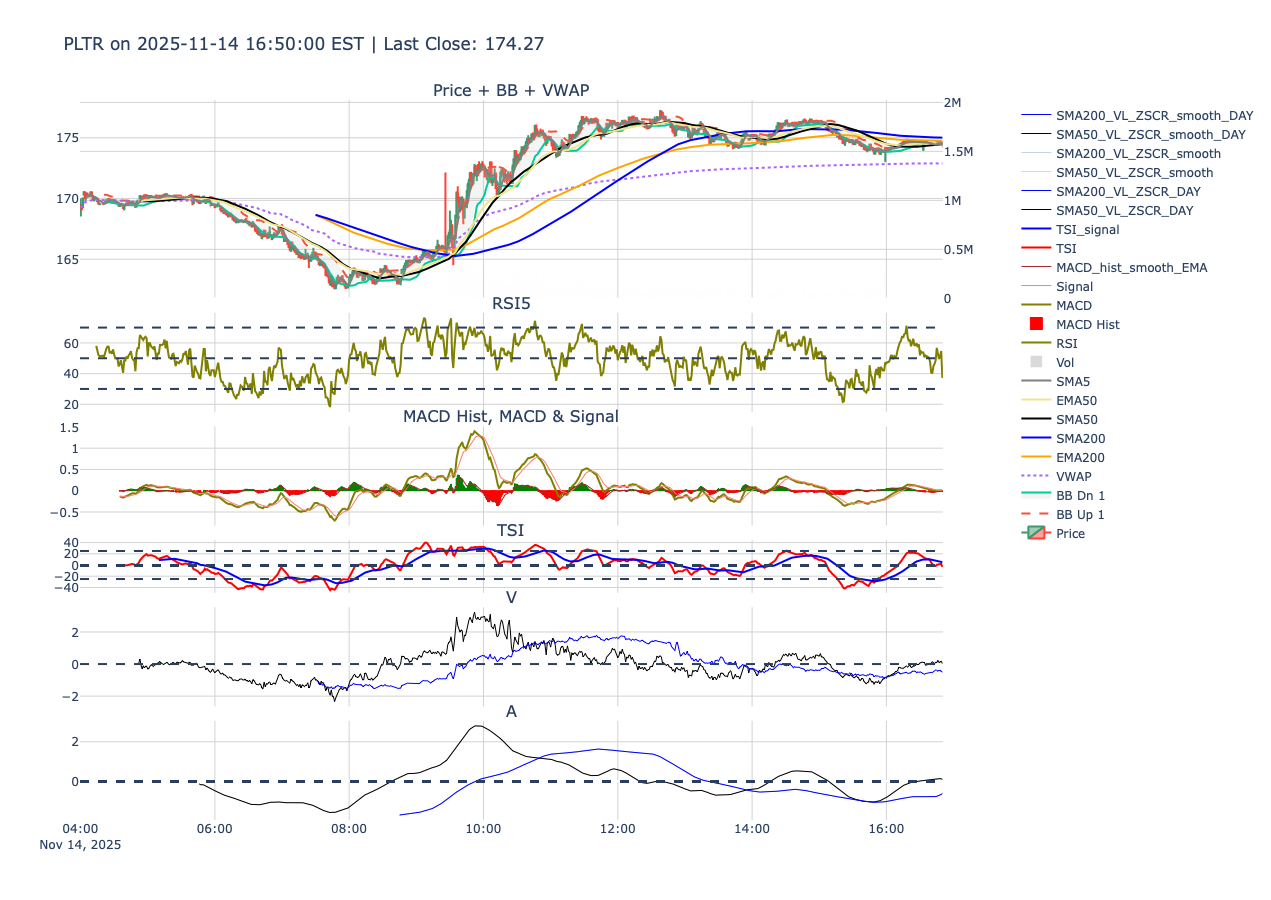

In [13]:
# Time window for filtering intraday bars (Eastern Time)

# ===== Inputs =====
# Add example 100 tickers

# Add example 100 tickers

TICKERS=['PLTR']

# Time window for filtering intraday bars (Eastern Time)

# ===== Inputs =====
start_date_DATA = date(2025, 11, 17)
end_date_DATA = date(2025, 11, 17)

start_time_DATA = dt_time(0, 0)   # ex.,4:00 AM ET
end_time_DATA = dt_time(20, 0)    #ex.,4:00 PM ET
#--------------------------------------------------
start_date_TRADE = date(2025, 11, 17)
end_date_TRADE = date(2025, 11, 17)

start_time_TRADE = dt_time(0, 0)   # ex.,4:00 AM ET
end_time_TRADE = dt_time(23, 59)    #ex.,4:00 PM ET

# ─────────────────────────────────────────────────────────────────────
# GET DATA
# ─────────────────────────────────────────────────────────────────────
multiplier = 1               #   e.g., 1-minute bars,  5-minute bars, etc.
timespan = "minute"          #  "second", "minute", "hour", "day", etc.
limit = 50000

all_data_minute = fetch_multiple_tickers_data(ticker=TICKERS,api_key=API_KEY,start_date=start_date_DATA,end_date=end_date_DATA,start_time=start_time_DATA,end_time=end_time_DATA,multiplier=multiplier,timespan=timespan,limit=limit)

# ─────────────────────────────────────────────────────────────────────
# Do the plot
# ─────────────────────────────────────────────────────────────────────
for tic in TICKERS:
    # df_day = all_data_minute_processed.get(tic)
    df_day = all_data_minute.get(tic)

    if df_day is None or df_day.empty:
        print(f"⚠️ {tic}: no data"); 
        continue

    fig = plot_intraday(df=df_day, ticker=tic)

    # Show regardless of library
    if hasattr(fig, "show"):          # Plotly Figure or Matplotlib Figure has .show()
        fig.show()
    else:
        try:
            display(fig)              # fallback for objects with rich repr
        except Exception:
            pass


✅ UP runs (diff ≥ 0): start ≥ 5 min positive, end after ≥ 6 min negative:


,Start EST,End EST,Open,Close,Δ,%Chg,Min,Avg5Diff,Start PST,End PST
0,08:46,11:43,163.3615,175.6950,12.3335,7.549820,177.0,7.427581,05:46,08:43
1,14:14,14:39,174.9800,176.1505,1.1705,0.668934,25.0,3.666297,11:14,11:39
2,15:52,16:28,173.8999,174.6500,0.7501,0.431340,36.0,2.487236,12:52,13:28
3,16:41,16:50,174.3900,174.2700,-0.1200,-0.068811,9.0,5.409453,13:41,13:50


✅ DOWN runs (diff < 0): start ≥ 5 min negative, end after ≥ 6 min positive:


,Start EST,End EST,Open,Close,Δ,%Chg,Min,Avg5Diff,Start PST,End PST
0,11:44,14:13,175.6499,174.8100,-0.8399,-0.478167,149.0,-3.921370,08:44,11:13
1,14:40,15:51,176.1405,174.1000,-2.0405,-1.158450,71.0,-5.485476,11:40,12:51
2,16:29,16:40,174.6900,174.4015,-0.2885,-0.165150,11.0,-1.528374,13:29,13:40


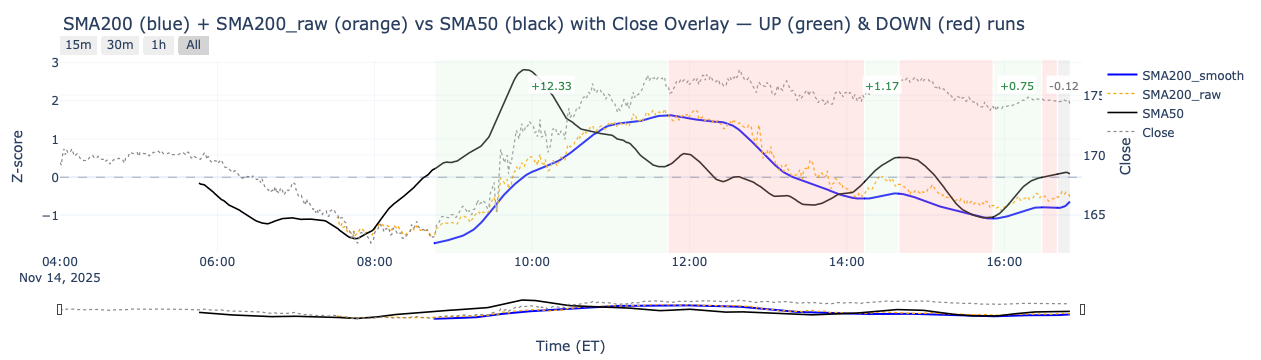

In [16]:
import pandas as pd
import numpy as np
from datetime import datetime
from zoneinfo import ZoneInfo
import plotly.graph_objects as go

# ─────────────────────────────────────────────────────────────────────
# CONFIG
# ─────────────────────────────────────────────────────────────────────
ET_ZONE  = ZoneInfo("America/New_York")
TZ_PST   = ZoneInfo("America/Los_Angeles")
TZ_EST   = ZoneInfo("America/New_York")

TIME_COL   = "TIME_EST"
COL        = "SMA200_VL_ZSCR_smooth_DAY"
CLOSE_COL  = "close"

COL_200     = "SMA200_VL_ZSCR_smooth_DAY"
COL_50      = "SMA50_VL_ZSCR_smooth_DAY"
COL_200_RAW = "SMA200_VL_ZSCR_DAY"

POS_MIN = pd.Timedelta(minutes=4)  # start confirmation (5 min)
NEG_MIN = pd.Timedelta(minutes=4)  # end confirmation   (6 min)

# ─────────────────────────────────────────────────────────────────────
# PREPARE WINDOW + DIFF
# ─────────────────────────────────────────────────────────────────────
df = df_day.copy()
df[TIME_COL] = pd.to_datetime(df[TIME_COL], errors="coerce")

start_time = datetime.combine(start_date_TRADE, start_time_TRADE, tzinfo=ET_ZONE)
end_time   = datetime.combine(end_date_TRADE,   end_time_TRADE,   tzinfo=ET_ZONE)

cols_to_keep = [TIME_COL, COL, CLOSE_COL]
mask = (df[TIME_COL] >= start_time) & (df[TIME_COL] <= end_time)
df_window = (
    df.loc[mask, cols_to_keep]
      .copy()
      .set_index(TIME_COL)
      .sort_index()
)
df_window = df_window[~df_window.index.duplicated(keep="first")]

df_window["diff"] = df_window[COL].diff()

diff_series = df_window["diff"].dropna().sort_index()
tmp = diff_series.reset_index()
tmp.columns = ["ts", "diff"]

# ─────────────────────────────────────────────────────────────────────
# GENERIC RUN DETECTION
# ─────────────────────────────────────────────────────────────────────
def detect_runs(tmp, start_cond, pos_min, neg_min):
    """
    start_cond(d): True for the main sign of the run
      - up  : d >= 0
      - down: d <  0
    Run starts after pos_min of start_cond
    Run ends  after neg_min of opposite sign
    """
    runs_list = []
    current_run_start = None
    streak_start = None        # streak for start_cond
    opp_streak_start = None    # streak for opposite sign
    last_main_ts = None        # last timestamp with start_cond(d) True

    for ts, d in tmp.itertuples(index=False):
        if np.isnan(d):
            continue

        if current_run_start is None:
            # Look for pos_min of start_cond to start a run
            if start_cond(d):
                if streak_start is None:
                    streak_start = ts
                if ts - streak_start >= pos_min:
                    current_run_start = streak_start
                    last_main_ts = ts
                    opp_streak_start = None
            else:
                streak_start = None
        else:
            # Inside an active run
            if start_cond(d):
                opp_streak_start = None
                last_main_ts = ts
            else:
                if opp_streak_start is None:
                    opp_streak_start = ts
                if ts - opp_streak_start >= neg_min:
                    run_end = last_main_ts if last_main_ts is not None else opp_streak_start
                    if run_end is not None and run_end > current_run_start:
                        runs_list.append((current_run_start, run_end))
                    current_run_start = None
                    streak_start = None
                    opp_streak_start = None
                    last_main_ts = None

    # If run still open at the end
    if current_run_start is not None:
        run_end = last_main_ts if last_main_ts is not None else tmp["ts"].iloc[-1]
        if run_end > current_run_start:
            runs_list.append((current_run_start, run_end))

    runs_df = pd.DataFrame(runs_list, columns=["run_start", "run_end"])
    if not runs_df.empty:
        runs_df["duration"] = runs_df["run_end"] - runs_df["run_start"]
        runs_df["duration_min"] = runs_df["duration"].dt.total_seconds() / 60.0
    else:
        runs_df["duration"] = pd.Timedelta(0)
        runs_df["duration_min"] = 0.0
    return runs_df

# ─────────────────────────────────────────────────────────────────────
# UP & DOWN RUNS (RAW)
# ─────────────────────────────────────────────────────────────────────
runs_up_raw   = detect_runs(tmp, lambda d: d >= 0, POS_MIN, NEG_MIN)
runs_down_raw = detect_runs(tmp, lambda d: d <  0, POS_MIN, NEG_MIN)

# ─────────────────────────────────────────────────────────────────────
# ENRICH RUNS: close + Δ + %Chg + Avg5Diff×1000
# ─────────────────────────────────────────────────────────────────────
def get_close_exact_or_asof(ts):
    if CLOSE_COL in df_window.columns:
        try:
            return float(df_window.loc[ts, CLOSE_COL])
        except KeyError:
            return float(df_window[CLOSE_COL].asof(ts))
    return np.nan

def enrich_runs(base_df, sign="up"):
    df_runs = base_df.copy()
    if df_runs.empty:
        return df_runs

    df_runs["run_start_close"] = df_runs["run_start"].map(get_close_exact_or_asof)
    df_runs["run_end_close"]   = df_runs["run_end"].map(get_close_exact_or_asof)

    df_runs["delta_close"] = df_runs["run_end_close"] - df_runs["run_start_close"]
    df_runs["pct_change"]  = np.where(
        df_runs["run_start_close"] != 0,
        (df_runs["delta_close"] / df_runs["run_start_close"]) * 100.0,
        np.nan
    )

    avg_first5_list = []
    for row in df_runs.itertuples(index=False):
        rs = row.run_start
        re = row.run_end
        seg = df_window.loc[(df_window.index >= rs) & (df_window.index <= re), "diff"]
        if sign == "up":
            seg_sign = seg[seg > 0]
        else:
            seg_sign = seg[seg < 0]
        if not seg_sign.empty:
            avg_first5_list.append(seg_sign.head(5).mean() * 1000)  # scale ×1000
        else:
            avg_first5_list.append(np.nan)

    df_runs["avg_first5_pos_diff"] = avg_first5_list
    return df_runs

runs_up_full   = enrich_runs(runs_up_raw,   sign="up")
runs_down_full = enrich_runs(runs_down_raw, sign="down")

# ─────────────────────────────────────────────────────────────────────
# SUMMARY TABLES
# ─────────────────────────────────────────────────────────────────────
def make_summary(df_runs):
    if df_runs.empty:
        return df_runs.copy()

    out = df_runs.copy().reset_index(drop=True)
    out["start_pst"] = out["run_start"].dt.tz_convert(TZ_PST)
    out["end_pst"]   = out["run_end"].dt.tz_convert(TZ_PST)
    out["start_est"] = out["run_start"].dt.tz_convert(TZ_EST)
    out["end_est"]   = out["run_end"].dt.tz_convert(TZ_EST)

    out["Start PST"] = out["start_pst"].dt.strftime("%H:%M")
    out["End PST"]   = out["end_pst"].dt.strftime("%H:%M")
    out["Start EST"] = out["start_est"].dt.strftime("%H:%M")
    out["End EST"]   = out["end_est"].dt.strftime("%H:%M")

    out = out.rename(columns={
        "run_start_close":     "Open",
        "run_end_close":       "Close",
        "delta_close":         "Δ",
        "pct_change":          "%Chg",
        "duration_min":        "Min",
        "avg_first5_pos_diff": "Avg5Diff"
    })[[
        "Start EST","End EST","Open","Close","Δ","%Chg","Min","Avg5Diff",
        "Start PST","End PST"
    ]]
    return out

runs_up   = make_summary(runs_up_full)
runs_down = make_summary(runs_down_full)

# For compatibility with previous cells:
runs      = runs_up.copy()
runs_plot = runs_up_full[["run_start","run_end"]].copy()

display(runs_up)
display(runs_down)

# ─────────────────────────────────────────────────────────────────────
# PLOT SMA200/SMA50/CLOSE + UP (green) + DOWN (red) SPANS
# ─────────────────────────────────────────────────────────────────────
# Build df_plot for SMA + close in ET
if TIME_COL in df.columns:
    ts_all = pd.to_datetime(df[TIME_COL], errors="coerce")
else:
    ts_all = pd.to_datetime(df.index, errors="coerce")
idx_all = pd.DatetimeIndex(ts_all)
idx_et  = idx_all.tz_localize(ET_ZONE, nonexistent="shift_forward", ambiguous="NaT") \
          if idx_all.tz is None else idx_all.tz_convert(ET_ZONE)

df_plot = df[[COL_200, COL_50, CLOSE_COL, COL_200_RAW]].copy()
df_plot.index = idx_et
df_plot = df_plot.sort_index()

start_dt = start_time
end_dt   = end_time
df_plot = df_plot.loc[(df_plot.index >= start_dt) & (df_plot.index <= end_dt)]
if df_plot.empty:
    raise ValueError("No data in the specified ET window for plotting.")

def to_et(ts_in):
    ts_in = pd.Timestamp(ts_in)
    return ts_in.replace(tzinfo=ET_ZONE) if ts_in.tzinfo is None else ts_in.tz_convert(ET_ZONE)

fig = go.Figure()

# SMA200 smoothed (blue)
fig.add_trace(go.Scatter(
    x=df_plot.index,
    y=df_plot[COL_200],
    mode="lines",
    line=dict(width=2, color="blue"),
    name="SMA200_smooth",
    customdata=np.stack([df_plot[COL_50], df_plot[CLOSE_COL]], axis=-1),
    hovertemplate=(
        "Time (ET): %{x|%H:%M}<br>"
        "SMA200_smooth: %{y:.3f}<br>"
        "SMA50: %{customdata[0]:.3f}<br>"
        "Close: %{customdata[1]:.4f}<extra></extra>"
    ),
))

# SMA200 raw (orange, dotted)
fig.add_trace(go.Scatter(
    x=df_plot.index,
    y=df_plot[COL_200_RAW],
    mode="lines",
    line=dict(width=1.3, color="orange", dash="dot"),
    name="SMA200_raw",
    hoverinfo="skip"
))

# SMA50 (black)
fig.add_trace(go.Scatter(
    x=df_plot.index,
    y=df_plot[COL_50],
    mode="lines",
    line=dict(width=1.6, color="black"),
    name="SMA50",
    hoverinfo="skip"
))

# Close (gray, right axis)
fig.add_trace(go.Scatter(
    x=df_plot.index,
    y=df_plot[CLOSE_COL],
    mode="lines",
    line=dict(width=1.2, dash="dot", color="#888"),
    name="Close",
    yaxis="y2",
    hoverinfo="skip"
))

# Spans & labels
shapes = []
annotations = []

# UP runs shading + Δ labels
if not runs_up_full.empty:
    delta_vals_up = runs_up_full["delta_close"].to_numpy()
    for i, r in enumerate(runs_up_full.itertuples(index=False)):
        start_et = to_et(r.run_start)
        end_et   = to_et(r.run_end)
        if end_et < start_dt or start_et > end_dt:
            continue
        seg_start = max(start_et, start_dt)
        seg_end   = min(end_et,   end_dt)
        dv = float(delta_vals_up[i]) if i < len(delta_vals_up) else np.nan
        if not np.isfinite(dv):
            continue

        fillcolor = "rgba(215,245,215,0.25)" if dv > 0 else "rgba(200,200,200,0.25)"
        shapes.append(dict(
            type="rect",
            xref="x", yref="paper",
            x0=seg_start, x1=seg_end, y0=0, y1=1,
            fillcolor=fillcolor, line=dict(width=0)
        ))

        x_mid = seg_start + (seg_end - seg_start) / 2
        annotations.append(dict(
            x=x_mid, y=0.92, xref="x", yref="paper",
            text=(f"+{dv:.2f}" if dv > 0 else f"{dv:.2f}"),
            showarrow=False,
            font=dict(size=11, color=("#1a7f37" if dv > 0 else "dimgray")),
            bgcolor="white", borderpad=2, opacity=0.9
        ))

# DOWN runs shading (light red)
if not runs_down_full.empty:
    for r in runs_down_full.itertuples(index=False):
        start_et = to_et(r.run_start)
        end_et   = to_et(r.run_end)
        if end_et < start_dt or start_et > end_dt:
            continue
        seg_start = max(start_et, start_dt)
        seg_end   = min(end_et,   end_dt)

        shapes.append(dict(
            type="rect",
            xref="x", yref="paper",
            x0=seg_start, x1=seg_end, y0=0, y1=1,
            fillcolor="rgba(255,180,180,0.28)",   # light red shadow
            line=dict(width=0)
        ))

fig.update_layout(
    title="SMA200 (blue) + SMA200_raw (orange) vs SMA50 (black) with Close Overlay — UP (green) & DOWN (red) runs",
    xaxis_title="Time (ET)",
    yaxis=dict(title="Z-score"),
    yaxis2=dict(
        title="Close",
        overlaying="y",
        side="right",
        showgrid=False
    ),
    template="plotly_white",
    hovermode="x unified",
    showlegend=True,
    shapes=shapes,
    annotations=annotations,
    margin=dict(l=60, r=50, t=60, b=40),
    hoverlabel=dict(bgcolor="white", bordercolor="rgba(0,0,0,0)", font=dict(color="black"))
)
fig.update_xaxes(showgrid=True, gridwidth=0.5)
fig.update_yaxes(showgrid=True, gridwidth=0.5)
fig.add_hline(y=0, line_width=1, line_dash="dash", opacity=0.7)

fig.update_xaxes(
    rangeslider=dict(visible=True, thickness=0.08),
    rangeselector=dict(
        buttons=[
            dict(step="minute", stepmode="backward", count=15, label="15m"),
            dict(step="minute", stepmode="backward", count=30, label="30m"),
            dict(step="hour",   stepmode="backward", count=1,  label="1h"),
            dict(step="all",    label="All")
        ]
    )
)

fig.show()


In [ ]:
UP runs (diff ≥ 0): start ≥ 5 min positive, end after ≥ 6 min negative:
Start EST	End EST	Open	Close	Δ	%Chg	Min	Avg5Diff	Start PST	End PST
0	08:46	11:43	163.3615	175.6950	12.3335	7.549820	177.0	7.427581	05:46	08:43
1	14:14	14:39	174.9800	176.1505	1.1705	0.668934	25.0	3.666297	11:14	11:39
2	15:52	16:28	173.8999	174.6500	0.7501	0.431340	36.0	2.487236	12:52	13:28
3	16:41	16:50	174.3900	174.2700	-0.1200	-0.068811	9.0	5.409453	13:41	13:50
✅ DOWN runs (diff < 0): start ≥ 5 min negative, end after ≥ 6 min positive:
Start EST	End EST	Open	Close	Δ	%Chg	Min	Avg5Diff	Start PST	End PST
0	11:44	14:13	175.6499	174.8100	-0.8399	-0.478167	149.0	-3.921370	08:44	11:13
1	14:40	15:51	176.1405	174.1000	-2.0405	-1.158450	71.0	-5.485476	11:40	12:51
2	16:29	16:40	174.6900	174.4015	-0.2885	-0.165150	11.0	-1.528374	13:29	13:40

✅ UP runs (diff ≥ 0): start ≥ 5 min positive, end after ≥ 6 min negative:


,Start EST,End EST,Open,Close,Δ,%Chg,Min,AvgDiff_UP_start,AvgDiff_UP_end,Start PST,End PST
0,08:46,11:43,163.3615,175.6950,12.3335,7.549820,177.0,7.427581,4.498450,05:46,08:43
1,14:14,14:39,174.9800,176.1505,1.1705,0.668934,25.0,3.666297,3.149557,11:14,11:39
2,15:52,16:28,173.8999,174.6500,0.7501,0.431340,36.0,2.487236,2.806017,12:52,13:28
3,16:41,16:50,174.3900,174.2700,-0.1200,-0.068811,9.0,5.409453,27.973667,13:41,13:50


✅ DOWN runs (diff < 0): start ≥ 5 min negative, end after ≥ 6 min positive:


,Start EST,End EST,Open,Close,Δ,%Chg,Min,AvgDiff_DOWN_start,AvgDiff_DOWN_end,Start PST,End PST
0,11:44,14:13,175.6499,174.8100,-0.8399,-0.478167,149.0,-3.921370,-3.125700,08:44,11:13
1,14:40,15:51,176.1405,174.1000,-2.0405,-1.158450,71.0,-5.485476,-2.386723,11:40,12:51
2,16:29,16:40,174.6900,174.4015,-0.2885,-0.165150,11.0,-1.528374,-2.222198,13:29,13:40


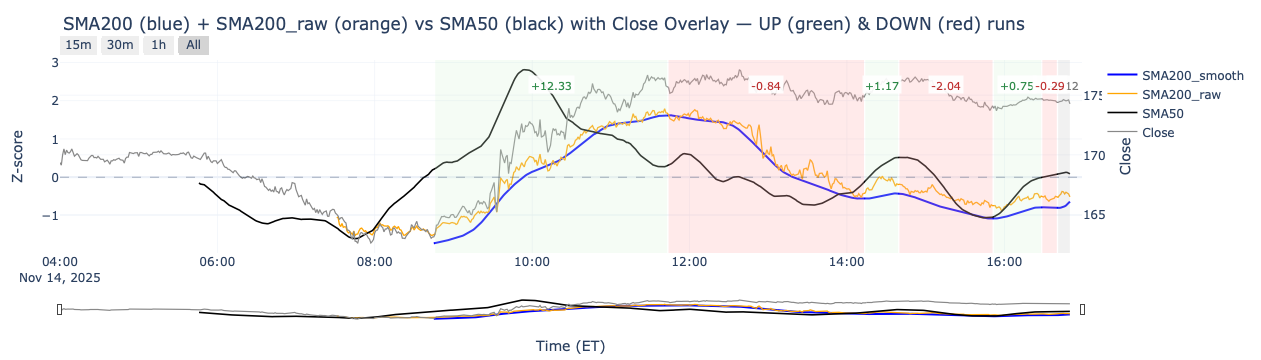

In [17]:
import pandas as pd
import numpy as np
from datetime import datetime
from zoneinfo import ZoneInfo
import plotly.graph_objects as go

# ─────────────────────────────────────────────────────────────────────
# CONFIG
# ─────────────────────────────────────────────────────────────────────
ET_ZONE  = ZoneInfo("America/New_York")
TZ_PST   = ZoneInfo("America/Los_Angeles")
TZ_EST   = ZoneInfo("America/New_York")

TIME_COL   = "TIME_EST"
COL        = "SMA200_VL_ZSCR_smooth_DAY"
CLOSE_COL  = "close"

COL_200     = "SMA200_VL_ZSCR_smooth_DAY"
COL_50      = "SMA50_VL_ZSCR_smooth_DAY"
COL_200_RAW = "SMA200_VL_ZSCR_DAY"

POS_MIN = pd.Timedelta(minutes=4)  # start confirmation (5 min)
NEG_MIN = pd.Timedelta(minutes=4)  # end confirmation   (6 min)

# ─────────────────────────────────────────────────────────────────────
# PREPARE WINDOW + DIFF
# ─────────────────────────────────────────────────────────────────────
df = df_day.copy()
df[TIME_COL] = pd.to_datetime(df[TIME_COL], errors="coerce")

start_time = datetime.combine(start_date_TRADE, start_time_TRADE, tzinfo=ET_ZONE)
end_time   = datetime.combine(end_date_TRADE,   end_time_TRADE,   tzinfo=ET_ZONE)

cols_to_keep = [TIME_COL, COL, CLOSE_COL]
mask = (df[TIME_COL] >= start_time) & (df[TIME_COL] <= end_time)
df_window = (
    df.loc[mask, cols_to_keep]
      .copy()
      .set_index(TIME_COL)
      .sort_index()
)
df_window = df_window[~df_window.index.duplicated(keep="first")]

df_window["diff"] = df_window[COL].diff()

diff_series = df_window["diff"].dropna().sort_index()
tmp = diff_series.reset_index()
tmp.columns = ["ts", "diff"]

# ─────────────────────────────────────────────────────────────────────
# GENERIC RUN DETECTION
# ─────────────────────────────────────────────────────────────────────
def detect_runs(tmp, start_cond, pos_min, neg_min):
    """
    start_cond(d): True for the main sign of the run
      - up  : d >= 0
      - down: d <  0
    Run starts after pos_min of start_cond
    Run ends  after neg_min of opposite sign
    """
    runs_list = []
    current_run_start = None
    streak_start = None        # streak for start_cond
    opp_streak_start = None    # streak for opposite sign
    last_main_ts = None        # last timestamp with start_cond(d) True

    for ts, d in tmp.itertuples(index=False):
        if np.isnan(d):
            continue

        if current_run_start is None:
            # Look for pos_min of start_cond to start a run
            if start_cond(d):
                if streak_start is None:
                    streak_start = ts
                if ts - streak_start >= pos_min:
                    current_run_start = streak_start
                    last_main_ts = ts
                    opp_streak_start = None
            else:
                streak_start = None
        else:
            # Inside an active run
            if start_cond(d):
                opp_streak_start = None
                last_main_ts = ts
            else:
                if opp_streak_start is None:
                    opp_streak_start = ts
                if ts - opp_streak_start >= neg_min:
                    run_end = last_main_ts if last_main_ts is not None else opp_streak_start
                    if run_end is not None and run_end > current_run_start:
                        runs_list.append((current_run_start, run_end))
                    current_run_start = None
                    streak_start = None
                    opp_streak_start = None
                    last_main_ts = None

    # If run still open at the end
    if current_run_start is not None:
        run_end = last_main_ts if last_main_ts is not None else tmp["ts"].iloc[-1]
        if run_end > current_run_start:
            runs_list.append((current_run_start, run_end))

    runs_df = pd.DataFrame(runs_list, columns=["run_start", "run_end"])
    if not runs_df.empty:
        runs_df["duration"] = runs_df["run_end"] - runs_df["run_start"]
        runs_df["duration_min"] = runs_df["duration"].dt.total_seconds() / 60.0
    else:
        runs_df["duration"] = pd.Timedelta(0)
        runs_df["duration_min"] = 0.0
    return runs_df

# ─────────────────────────────────────────────────────────────────────
# UP & DOWN RUNS (RAW)
# ─────────────────────────────────────────────────────────────────────
runs_up_raw   = detect_runs(tmp, lambda d: d >= 0, POS_MIN, NEG_MIN)
runs_down_raw = detect_runs(tmp, lambda d: d <  0, POS_MIN, NEG_MIN)

# ─────────────────────────────────────────────────────────────────────
# ENRICH RUNS: close + Δ + %Chg + AvgDiff(start/end)×1000
# ─────────────────────────────────────────────────────────────────────
def get_close_exact_or_asof(ts):
    if CLOSE_COL in df_window.columns:
        try:
            return float(df_window.loc[ts, CLOSE_COL])
        except KeyError:
            return float(df_window[CLOSE_COL].asof(ts))
    return np.nan

def enrich_runs(base_df, sign="up"):
    df_runs = base_df.copy()
    if df_runs.empty:
        return df_runs

    df_runs["run_start_close"] = df_runs["run_start"].map(get_close_exact_or_asof)
    df_runs["run_end_close"]   = df_runs["run_end"].map(get_close_exact_or_asof)

    df_runs["delta_close"] = df_runs["run_end_close"] - df_runs["run_start_close"]
    df_runs["pct_change"]  = np.where(
        df_runs["run_start_close"] != 0,
        (df_runs["delta_close"] / df_runs["run_start_close"]) * 100.0,
        np.nan
    )

    avg_first5_list = []
    avg_last5_list  = []
    for row in df_runs.itertuples(index=False):
        rs = row.run_start
        re = row.run_end
        seg = df_window.loc[(df_window.index >= rs) & (df_window.index <= re), "diff"]
        if sign == "up":
            seg_sign = seg[seg > 0]
        else:
            seg_sign = seg[seg < 0]
        if not seg_sign.empty:
            avg_first5_list.append(seg_sign.head(5).mean() * 1000)  # start of run
            avg_last5_list.append(seg_sign.tail(5).mean() * 1000)   # end of run
        else:
            avg_first5_list.append(np.nan)
            avg_last5_list.append(np.nan)

    df_runs["avgdiff_start"] = avg_first5_list
    df_runs["avgdiff_end"]   = avg_last5_list
    return df_runs

runs_up_full   = enrich_runs(runs_up_raw,   sign="up")
runs_down_full = enrich_runs(runs_down_raw, sign="down")

# ─────────────────────────────────────────────────────────────────────
# SUMMARY TABLES
# ─────────────────────────────────────────────────────────────────────
def make_summary(df_runs, sign="up"):
    if df_runs.empty:
        return df_runs.copy()

    out = df_runs.copy().reset_index(drop=True)
    out["start_pst"] = out["run_start"].dt.tz_convert(TZ_PST)
    out["end_pst"]   = out["run_end"].dt.tz_convert(TZ_PST)
    out["start_est"] = out["run_start"].dt.tz_convert(TZ_EST)
    out["end_est"]   = out["run_end"].dt.tz_convert(TZ_EST)

    out["Start PST"] = out["start_pst"].dt.strftime("%H:%M")
    out["End PST"]   = out["end_pst"].dt.strftime("%H:%M")
    out["Start EST"] = out["start_est"].dt.strftime("%H:%M")
    out["End EST"]   = out["end_est"].dt.strftime("%H:%M")

    # Sign-aware names for avg diffs
    avg_start_col = f"AvgDiff_{sign.upper()}_start"
    avg_end_col   = f"AvgDiff_{sign.upper()}_end"

    out = out.rename(columns={
        "run_start_close":     "Open",
        "run_end_close":       "Close",
        "delta_close":         "Δ",
        "pct_change":          "%Chg",
        "duration_min":        "Min",
        "avgdiff_start":       avg_start_col,
        "avgdiff_end":         avg_end_col,
    })[[
        "Start EST","End EST","Open","Close","Δ","%Chg","Min",
        avg_start_col, avg_end_col,
        "Start PST","End PST"
    ]]
    return out

runs_up   = make_summary(runs_up_full,   sign="up")
runs_down = make_summary(runs_down_full, sign="down")

# For compatibility with previous cells:
runs      = runs_up.copy()
runs_plot = runs_up_full[["run_start","run_end"]].copy()

print(f"✅ UP runs (diff ≥ 0): start ≥ 5 min positive, end after ≥ 6 min negative:")
display(runs_up)

print(f"✅ DOWN runs (diff < 0): start ≥ 5 min negative, end after ≥ 6 min positive:")
display(runs_down)

# ─────────────────────────────────────────────────────────────────────
# PLOT SMA200/SMA50/CLOSE + UP (green) + DOWN (red) SPANS
# ─────────────────────────────────────────────────────────────────────
# Build df_plot for SMA + close in ET
if TIME_COL in df.columns:
    ts_all = pd.to_datetime(df[TIME_COL], errors="coerce")
else:
    ts_all = pd.to_datetime(df.index, errors="coerce")
idx_all = pd.DatetimeIndex(ts_all)
idx_et  = idx_all.tz_localize(ET_ZONE, nonexistent="shift_forward", ambiguous="NaT") \
          if idx_all.tz is None else idx_all.tz_convert(ET_ZONE)

df_plot = df[[COL_200, COL_50, CLOSE_COL, COL_200_RAW]].copy()
df_plot.index = idx_et
df_plot = df_plot.sort_index()

start_dt = start_time
end_dt   = end_time
df_plot = df_plot.loc[(df_plot.index >= start_dt) & (df_plot.index <= end_dt)]
if df_plot.empty:
    raise ValueError("No data in the specified ET window for plotting.")

def to_et(ts_in):
    ts_in = pd.Timestamp(ts_in)
    return ts_in.replace(tzinfo=ET_ZONE) if ts_in.tzinfo is None else ts_in.tz_convert(ET_ZONE)

fig = go.Figure()

# SMA200 smoothed (blue)
fig.add_trace(go.Scatter(
    x=df_plot.index,
    y=df_plot[COL_200],
    mode="lines",
    line=dict(width=2, color="blue"),
    name="SMA200_smooth",
    customdata=np.stack([df_plot[COL_50], df_plot[CLOSE_COL]], axis=-1),
    hovertemplate=(
        "Time (ET): %{x|%H:%M}<br>"
        "SMA200_smooth: %{y:.3f}<br>"
        "SMA50: %{customdata[0]:.3f}<br>"
        "Close: %{customdata[1]:.4f}<extra></extra>"
    ),
))

# SMA200 raw (orange, now SOLID)
fig.add_trace(go.Scatter(
    x=df_plot.index,
    y=df_plot[COL_200_RAW],
    mode="lines",
    line=dict(width=1.3, color="orange"),  # removed dash="dot"
    name="SMA200_raw",
    hoverinfo="skip"
))

# SMA50 (black)
fig.add_trace(go.Scatter(
    x=df_plot.index,
    y=df_plot[COL_50],
    mode="lines",
    line=dict(width=1.6, color="black"),
    name="SMA50",
    hoverinfo="skip"
))

# Close (gray, right axis) — now SOLID
fig.add_trace(go.Scatter(
    x=df_plot.index,
    y=df_plot[CLOSE_COL],
    mode="lines",
    line=dict(width=1.2, color="#888"),   # removed dash="dot"
    name="Close",
    yaxis="y2",
    hoverinfo="skip"
))

# Spans & labels
shapes = []
annotations = []

# UP runs shading + Δ labels
if not runs_up_full.empty:
    delta_vals_up = runs_up_full["delta_close"].to_numpy()
    for i, r in enumerate(runs_up_full.itertuples(index=False)):
        start_et = to_et(r.run_start)
        end_et   = to_et(r.run_end)
        if end_et < start_dt or start_et > end_dt:
            continue
        seg_start = max(start_et, start_dt)
        seg_end   = min(end_et,   end_dt)
        dv = float(delta_vals_up[i]) if i < len(delta_vals_up) else np.nan
        if not np.isfinite(dv):
            continue

        fillcolor = "rgba(215,245,215,0.25)" if dv > 0 else "rgba(200,200,200,0.25)"
        shapes.append(dict(
            type="rect",
            xref="x", yref="paper",
            x0=seg_start, x1=seg_end, y0=0, y1=1,
            fillcolor=fillcolor, line=dict(width=0)
        ))

        x_mid = seg_start + (seg_end - seg_start) / 2
        annotations.append(dict(
            x=x_mid, y=0.92, xref="x", yref="paper",
            text=(f"+{dv:.2f}" if dv > 0 else f"{dv:.2f}"),
            showarrow=False,
            font=dict(size=11, color=("#1a7f37" if dv > 0 else "dimgray")),
            bgcolor="white", borderpad=2, opacity=0.9
        ))

# DOWN runs shading (light red) + Δ labels
if not runs_down_full.empty:
    delta_vals_down = runs_down_full["delta_close"].to_numpy()
    for i, r in enumerate(runs_down_full.itertuples(index=False)):
        start_et = to_et(r.run_start)
        end_et   = to_et(r.run_end)
        if end_et < start_dt or start_et > end_dt:
            continue
        seg_start = max(start_et, start_dt)
        seg_end   = min(end_et,   end_dt)

        shapes.append(dict(
            type="rect",
            xref="x", yref="paper",
            x0=seg_start, x1=seg_end, y0=0, y1=1,
            fillcolor="rgba(255,180,180,0.28)",   # light red shadow
            line=dict(width=0)
        ))

        dv = float(delta_vals_down[i]) if i < len(delta_vals_down) else np.nan
        if not np.isfinite(dv):
            continue
        x_mid = seg_start + (seg_end - seg_start) / 2
        annotations.append(dict(
            x=x_mid, y=0.92, xref="x", yref="paper",
            text=f"{dv:.2f}",      # typically negative
            showarrow=False,
            font=dict(size=11, color="#b91c1c"),
            bgcolor="white", borderpad=2, opacity=0.9
        ))

fig.update_layout(
    title="SMA200 (blue) + SMA200_raw (orange) vs SMA50 (black) with Close Overlay — UP (green) & DOWN (red) runs",
    xaxis_title="Time (ET)",
    yaxis=dict(title="Z-score"),
    yaxis2=dict(
        title="Close",
        overlaying="y",
        side="right",
        showgrid=False
    ),
    template="plotly_white",
    hovermode="x unified",
    showlegend=True,
    shapes=shapes,
    annotations=annotations,
    margin=dict(l=60, r=50, t=60, b=40),
    hoverlabel=dict(bgcolor="white", bordercolor="rgba(0,0,0,0)", font=dict(color="black"))
)
fig.update_xaxes(showgrid=True, gridwidth=0.5)
fig.update_yaxes(showgrid=True, gridwidth=0.5)
fig.add_hline(y=0, line_width=1, line_dash="dash", opacity=0.7)

fig.update_xaxes(
    rangeslider=dict(visible=True, thickness=0.08),
    rangeselector=dict(
        buttons=[
            dict(step="minute", stepmode="backward", count=15, label="15m"),
            dict(step="minute", stepmode="backward", count=30, label="30m"),
            dict(step="hour",   stepmode="backward", count=1,  label="1h"),
            dict(step="all",    label="All")
        ]
    )
)

fig.show()


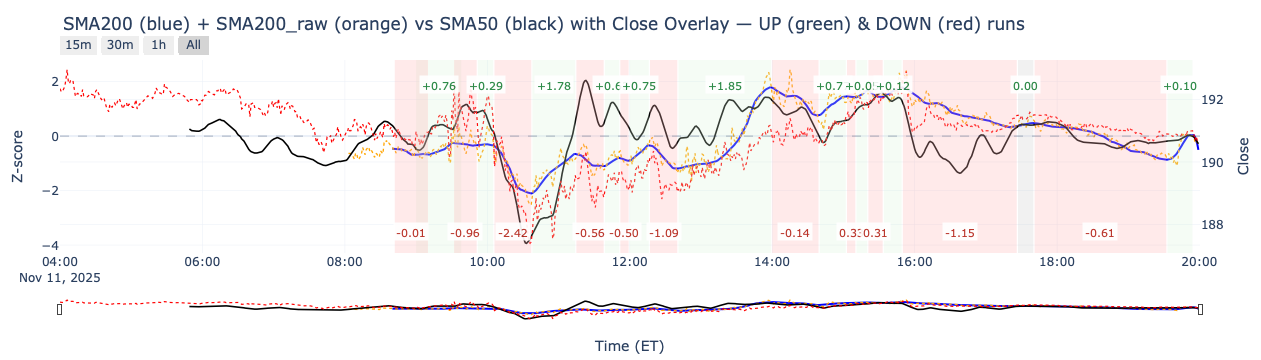

In [14]:
# ─────────────────────────────────────────────────────────────────────
# PLOT SMA200/SMA50/CLOSE + UP (green) + DOWN (red) SPANS + Δ LABELS
# ─────────────────────────────────────────────────────────────────────
# Build df_plot for SMA + close in ET
if TIME_COL in df.columns:
    ts_all = pd.to_datetime(df[TIME_COL], errors="coerce")
else:
    ts_all = pd.to_datetime(df.index, errors="coerce")
idx_all = pd.DatetimeIndex(ts_all)
idx_et  = idx_all.tz_localize(ET_ZONE, nonexistent="shift_forward", ambiguous="NaT") \
          if idx_all.tz is None else idx_all.tz_convert(ET_ZONE)

df_plot = df[[COL_200, COL_50, CLOSE_COL, COL_200_RAW]].copy()
df_plot.index = idx_et
df_plot = df_plot.sort_index()

start_dt = start_time
end_dt   = end_time
df_plot = df_plot.loc[(df_plot.index >= start_dt) & (df_plot.index <= end_dt)]
if df_plot.empty:
    raise ValueError("No data in the specified ET window for plotting.")

def to_et(ts_in):
    ts_in = pd.Timestamp(ts_in)
    return ts_in.replace(tzinfo=ET_ZONE) if ts_in.tzinfo is None else ts_in.tz_convert(ET_ZONE)

fig = go.Figure()

# SMA200 smoothed (blue)
fig.add_trace(go.Scatter(
    x=df_plot.index,
    y=df_plot[COL_200],
    mode="lines",
    line=dict(width=2, color="blue"),
    name="SMA200_smooth",
    customdata=np.stack([df_plot[COL_50], df_plot[CLOSE_COL]], axis=-1),
    hovertemplate=(
        "Time (ET): %{x|%H:%M}<br>"
        "SMA200_smooth: %{y:.3f}<br>"
        "SMA50: %{customdata[0]:.3f}<br>"
        "Close: %{customdata[1]:.4f}<extra></extra>"
    ),
))

# SMA200 raw (orange, dotted)
fig.add_trace(go.Scatter(
    x=df_plot.index,
    y=df_plot[COL_200_RAW],
    mode="lines",
    line=dict(width=1.3, color="orange", dash="dot"),
    name="SMA200_raw",
    hoverinfo="skip"
))

# SMA50 (black)
fig.add_trace(go.Scatter(
    x=df_plot.index,
    y=df_plot[COL_50],
    mode="lines",
    line=dict(width=1.6, color="black"),
    name="SMA50",
    hoverinfo="skip"
))

# Close (red, right axis)
fig.add_trace(go.Scatter(
    x=df_plot.index,
    y=df_plot[CLOSE_COL],
    mode="lines",
    line=dict(width=1.2, dash="dot", color="red"),
    name="Close",
    yaxis="y2",
    hoverinfo="skip"
))

# Spans & labels
shapes = []
annotations = []

# UP runs shading + Δ labels (green)
if not runs_up_full.empty:
    delta_vals_up = runs_up_full["delta_close"].to_numpy()
    for i, r in enumerate(runs_up_full.itertuples(index=False)):
        start_et = to_et(r.run_start)
        end_et   = to_et(r.run_end)
        if end_et < start_dt or start_et > end_dt:
            continue
        seg_start = max(start_et, start_dt)
        seg_end   = min(end_et,   end_dt)

        dv = float(delta_vals_up[i]) if i < len(delta_vals_up) else np.nan
        if not np.isfinite(dv):
            continue

        fillcolor = "rgba(215,245,215,0.25)" if dv > 0 else "rgba(200,200,200,0.25)"
        shapes.append(dict(
            type="rect",
            xref="x", yref="paper",
            x0=seg_start, x1=seg_end, y0=0, y1=1,
            fillcolor=fillcolor, line=dict(width=0)
        ))

        x_mid = seg_start + (seg_end - seg_start) / 2
        annotations.append(dict(
            x=x_mid, y=0.92, xref="x", yref="paper",
            text=(f"+{dv:.2f}" if dv > 0 else f"{dv:.2f}"),
            showarrow=False,
            font=dict(size=11, color="#1a7f37"),  # green text
            bgcolor="white", borderpad=2, opacity=0.9
        ))

# DOWN runs shading + Δ labels (red)
if not runs_down_full.empty:
    delta_vals_down = runs_down_full["delta_close"].to_numpy()
    for i, r in enumerate(runs_down_full.itertuples(index=False)):
        start_et = to_et(r.run_start)
        end_et   = to_et(r.run_end)
        if end_et < start_dt or start_et > end_dt:
            continue
        seg_start = max(start_et, start_dt)
        seg_end   = min(end_et,   end_dt)

        dv = float(delta_vals_down[i]) if i < len(delta_vals_down) else np.nan
        if not np.isfinite(dv):
            continue

        shapes.append(dict(
            type="rect",
            xref="x", yref="paper",
            x0=seg_start, x1=seg_end, y0=0, y1=1,
            fillcolor="rgba(255,180,180,0.28)",   # light red
            line=dict(width=0)
        ))

        x_mid = seg_start + (seg_end - seg_start) / 2
        annotations.append(dict(
            x=x_mid, y=0.06, xref="x", yref="paper",
            text=f"{dv:.2f}",  # negative or positive, but these should be ≤ 0
            showarrow=False,
            font=dict(size=11, color="#b42318"),  # red text
            bgcolor="white", borderpad=2, opacity=0.9
        ))

fig.update_layout(
    title="SMA200 (blue) + SMA200_raw (orange) vs SMA50 (black) with Close Overlay — UP (green) & DOWN (red) runs",
    xaxis_title="Time (ET)",
    yaxis=dict(title="Z-score"),
    yaxis2=dict(
        title="Close",
        overlaying="y",
        side="right",
        showgrid=False
    ),
    template="plotly_white",
    hovermode="x unified",
    showlegend=False,
    shapes=shapes,
    annotations=annotations,
    margin=dict(l=60, r=50, t=60, b=40),
    hoverlabel=dict(bgcolor="white", bordercolor="rgba(0,0,0,0)", font=dict(color="black"))
)

fig.update_xaxes(showgrid=True, gridwidth=0.5)
fig.update_yaxes(showgrid=True, gridwidth=0.5)
fig.add_hline(y=0, line_width=1, line_dash="dash", opacity=0.7)

# Cleaned rangeslider / rangeselector (removed stray text that caused a syntax error)
fig.update_xaxes(
    rangeslider=dict(visible=True, thickness=0.08),
    rangeselector=dict(
        buttons=[
            dict(step="minute", stepmode="backward", count=15, label="15m"),
            dict(step="minute", stepmode="backward", count=30, label="30m"),
            dict(step="hour",   stepmode="backward", count=1,  label="1h"),
            dict(step="all",    label="All")
        ]
    )
)

fig.show()


In [59]:
import pandas as pd
import numpy as np
from datetime import date, time as dt_time
from scipy.signal import savgol_filter
from scipy.stats import zscore
import talib
import pandas_ta as ta

df= df_day.copy()

start_time = dt_time(4, 0)   # 4:00 AM ET
end_time = dt_time(23, 59)    # 4:00 PM ET

mask = (df['TIME_EST'].dt.time >= start_time) & (df['TIME_EST'].dt.time <= end_time)
df_trading = df.loc[mask].copy()

df.loc[mask, 'VWAP_Cum'] = (
    (df.loc[mask, 'close'] * df.loc[mask, 'volume']).groupby(df.loc[mask, 'TIME_EST'].dt.date).cumsum() /
    df.loc[mask, 'volume'].groupby(df.loc[mask, 'TIME_EST'].dt.date).cumsum()
)

# EMA, MACD, ATR, SMA _______________________________________________
macd, sig, hist = talib.MACD(df.close.values, fastperiod=12, slowperiod=26, signalperiod=9)
df['MACD'], df['Signal'], df['MACD_hist'] = macd, sig, hist

df['EMA9']   = talib.EMA(df.close.values, timeperiod=9)
df['EMA20']  = talib.EMA(df.close.values, timeperiod=20)
df['EMA50']  = talib.EMA(df.close.values, timeperiod=50)
df['EMA200'] = talib.EMA(df.close.values, timeperiod=200)

df['MACD_hist_smooth_EMA'] = df['MACD_hist'].ewm(span=5, adjust=False).mean()

df['SMA5']   = talib.SMA(df.close.values, timeperiod=5)
df['SMA20']  = talib.SMA(df.close.values, timeperiod=20)
df['SMA50']  = talib.SMA(df.close.values, timeperiod=50)
df['SMA200'] = talib.SMA(df.close.values, timeperiod=200)


# Confirming Signal --------------------------------------------------
df['SMA200_VL'] = df['SMA200'].diff()
df['SMA50_VL']  = df['SMA50'].diff()

# zscored_signal = zscore(df[['SMA50_VL', 'SMA200_VL']].values, axis=0, ddof=0, nan_policy='omit')
# df[['SMA50_VL_ZSCR', 'SMA200_VL_ZSCR']] = zscored_signal

_seg = df.loc[mask] 

out = (
    _seg
    .groupby(_seg['TIME_EST'].dt.date, group_keys=False)[['SMA50_VL','SMA200_VL']]
    .apply(lambda g: pd.DataFrame(
        zscore(g.to_numpy(), axis=0, ddof=0, nan_policy='omit'),
        index=g.index,
        columns=['SMA50_VL_ZSCR_DAY','SMA200_VL_ZSCR_DAY']
    ))
)

# Assign back aligned by index
df[['SMA50_VL_ZSCR_DAY','SMA200_VL_ZSCR_DAY']] = np.nan
df.loc[out.index, ['SMA50_VL_ZSCR_DAY','SMA200_VL_ZSCR_DAY']] = out


# Smoothed Signal ----------------------------------------------------
# df['SMA200_VL_gauss'] = gaussian_filter1d(df['SMA200_VL'], sigma=3)
# df['SMA200_VL_smooth'] = savgol_filter(df['SMA200_VL_gauss'], window_length=95, polyorder=3)

df['SMA50_VL_smooth']  = savgol_filter(df['SMA50_VL'],  window_length=100, polyorder=7)
df['SMA200_VL_smooth'] = savgol_filter(df['SMA200_VL'], window_length=150, polyorder=7)

zscored_signal = zscore(df[['SMA50_VL_smooth', 'SMA200_VL_smooth']].values, axis=0, ddof=0, nan_policy='omit')
df[['SMA50_VL_ZSCR_smooth', 'SMA200_VL_ZSCR_smooth']] = zscored_signal

# --- Daily z-score of the diff columns (resets each day) ---
_seg = df.loc[mask] 

out = (
    _seg
    .groupby(_seg['TIME_EST'].dt.date, group_keys=False)[['SMA50_VL_smooth','SMA200_VL_smooth']]
    .apply(lambda g: pd.DataFrame(
        zscore(g.to_numpy(), axis=0, ddof=0, nan_policy='omit'),
        index=g.index,
        columns=['SMA50_VL_ZSCR_smooth_DAY','SMA200_VL_ZSCR_smooth_DAY']
    ))
)

# Assign back aligned by index
df[['SMA50_VL_ZSCR_smooth_DAY','SMA200_VL_ZSCR_smooth_DAY']] = np.nan
df.loc[out.index, ['SMA50_VL_ZSCR_smooth_DAY','SMA200_VL_ZSCR_smooth_DAY']] = out



<Figure size 1200x500 with 0 Axes>

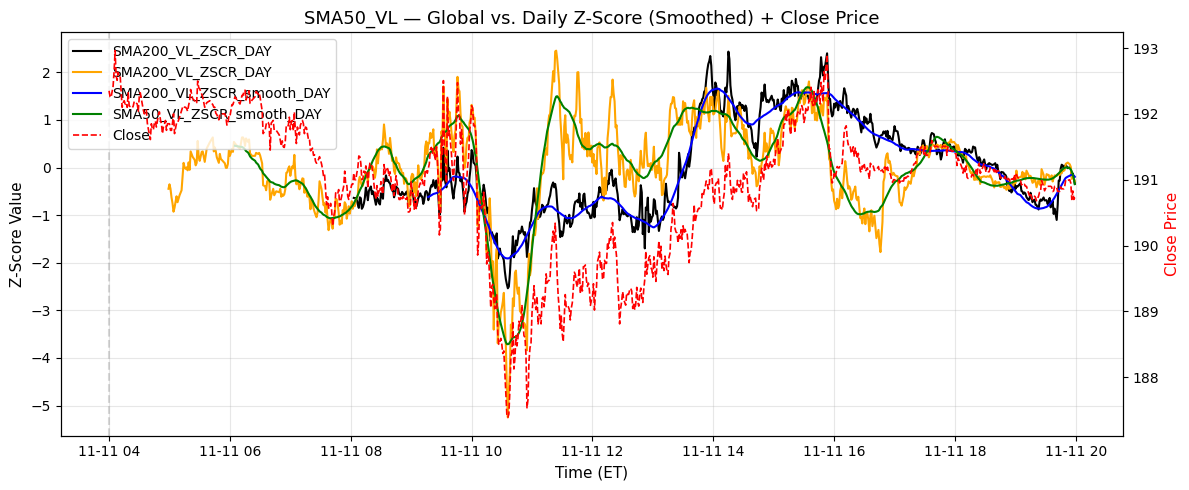

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Create main axis for Z-score data
fig, ax1 = plt.subplots(figsize=(12,5))

# --- Plot Z-score series ---
ax1.plot(df['TIME_EST'], df['SMA200_VL_ZSCR_DAY'], color='black', lw=1.5, label='SMA200_VL_ZSCR_DAY')
ax1.plot(df['TIME_EST'], df['SMA50_VL_ZSCR_DAY'], color='orange', lw=1.5, label='SMA200_VL_ZSCR_DAY')

ax1.plot(df['TIME_EST'], df['SMA200_VL_ZSCR_smooth_DAY'], color='blue', lw=1.5, label='SMA200_VL_ZSCR_smooth_DAY')
ax1.plot(df['TIME_EST'], df['SMA50_VL_ZSCR_smooth_DAY'],  color='g', lw=1.5, label='SMA50_VL_ZSCR_smooth_DAY')

# Shade day boundaries
for d in df['TIME_EST'].dt.date.unique():
    x0 = df.loc[df['TIME_EST'].dt.date == d, 'TIME_EST'].iloc[0]
    ax1.axvline(x=x0, ls='--', color='gray', alpha=0.3)

# --- Create second axis for close price ---
ax2 = ax1.twinx()
ax2.plot(df['TIME_EST'], df['close'], color='red', lw=1.2, ls='--', label='Close')

# --- Axis labeling ---
ax1.set_xlabel("Time (ET)", fontsize=11)
ax1.set_ylabel("Z-Score Value", color='black', fontsize=11)
ax2.set_ylabel("Close Price", color='red', fontsize=11)

# --- Title, legends, and grid ---
ax1.set_title("SMA50_VL — Global vs. Daily Z-Score (Smoothed) + Close Price", fontsize=13)
ax1.grid(alpha=0.3)

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

plt.tight_layout()
plt.show()


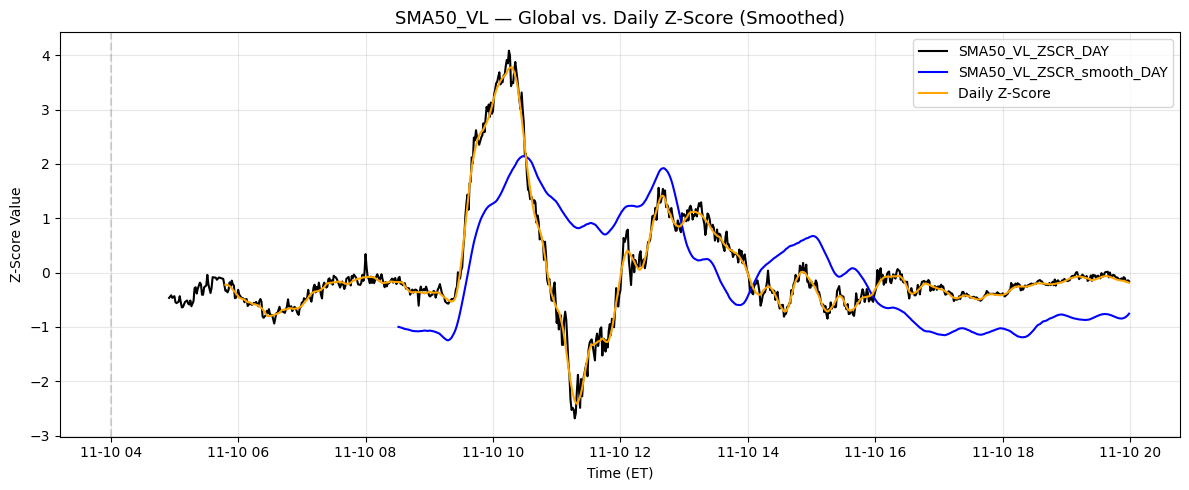

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Plot both versions
plt.plot(df['TIME_EST'], df['SMA50_VL_ZSCR_DAY'], color='black', lw=1.5, label='SMA50_VL_ZSCR_DAY')
plt.plot(df['TIME_EST'], df['SMA200_VL_ZSCR_smooth_DAY'], color='blue',  lw=1.5, label='SMA50_VL_ZSCR_smooth_DAY')
plt.plot(df['TIME_EST'], df['SMA50_VL_ZSCR_smooth_DAY'], color='orange', lw=1.5, label='Daily Z-Score')

# Shade day boundaries
for d in df['TIME_EST'].dt.date.unique():
    x0 = df.loc[df['TIME_EST'].dt.date==d, 'TIME_EST'].iloc[0]
    plt.axvline(x0, ls='--', color='gray', alpha=0.3)

plt.title("SMA50_VL — Global vs. Daily Z-Score (Smoothed)", fontsize=13)
plt.xlabel("Time (ET)")
plt.ylabel("Z-Score Value")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


<Figure size 1200x500 with 0 Axes>

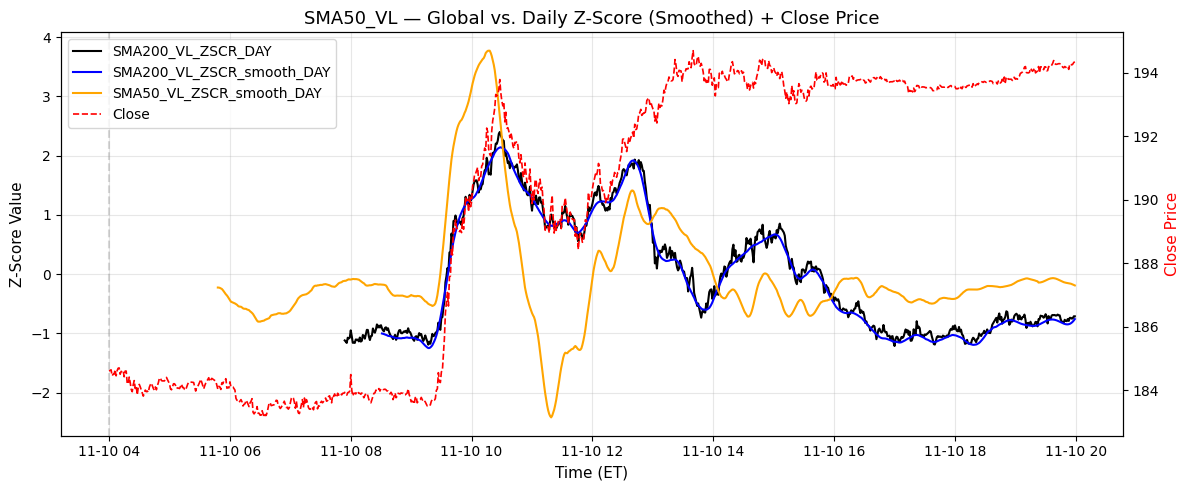

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Create main axis for Z-score data
fig, ax1 = plt.subplots(figsize=(12,5))

# --- Plot Z-score series ---
ax1.plot(df['TIME_EST'], df['SMA200_VL_ZSCR_DAY'], 
         color='black', lw=1.5, label='SMA200_VL_ZSCR_DAY')
ax1.plot(df['TIME_EST'], df['SMA200_VL_ZSCR_smooth_DAY'], 
         color='blue', lw=1.5, label='SMA200_VL_ZSCR_smooth_DAY')
ax1.plot(df['TIME_EST'], df['SMA50_VL_ZSCR_smooth_DAY'], 
         color='orange', lw=1.5, label='SMA50_VL_ZSCR_smooth_DAY')

# Shade day boundaries
for d in df['TIME_EST'].dt.date.unique():
    x0 = df.loc[df['TIME_EST'].dt.date == d, 'TIME_EST'].iloc[0]
    ax1.axvline(x=x0, ls='--', color='gray', alpha=0.3)

# --- Create second axis for close price ---
ax2 = ax1.twinx()
ax2.plot(df['TIME_EST'], df['close'], color='red', lw=1.2, ls='--', label='Close')

# --- Axis labeling ---
ax1.set_xlabel("Time (ET)", fontsize=11)
ax1.set_ylabel("Z-Score Value", color='black', fontsize=11)
ax2.set_ylabel("Close Price", color='red', fontsize=11)

# --- Title, legends, and grid ---
ax1.set_title("SMA50_VL — Global vs. Daily Z-Score (Smoothed) + Close Price", fontsize=13)
ax1.grid(alpha=0.3)

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

plt.tight_layout()
plt.show()


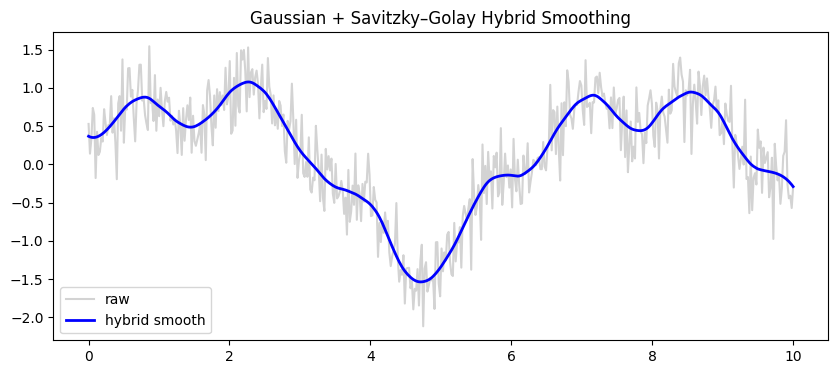

In [33]:
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

# ---- Example signal ----
np.random.seed(0)
x = np.linspace(0, 10, 500)
signal = (
    np.sin(x) * (1 + 0.5*np.sin(3*x))   # multiple local oscillations
    + 0.3*np.random.randn(len(x))        # noise
)

# ---- Step 1. Remove local noise with Gaussian smoothing ----
sigma = 3   # controls the "neighborhood" width (higher = smoother)
smooth_gauss = gaussian_filter1d(signal, sigma=sigma)

# ---- Step 2. Preserve slope using Savitzky–Golay ----
window = 51    # must be odd
poly   = 3
smooth_final = savgol_filter(smooth_gauss, window_length=window, polyorder=poly)

# ---- Plot ----
plt.figure(figsize=(10,4))
plt.plot(x, signal, color='lightgray', label='raw')
plt.plot(x, smooth_final, color='blue', lw=2, label='hybrid smooth')
plt.legend(); plt.title('Gaussian + Savitzky–Golay Hybrid Smoothing');
plt.show()
